In [2]:
from matplotlib import lines
import wandb
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
import colorsys
import re

from collections import defaultdict
import numpy as np
import jax


plt.style.use(["science", "grid"])

# Reference data

In [3]:
energies_kcal_per_mol = {
    "naphthalene": [61.0, -3.4, 64.4, 68.0, 62.6, 65.8, 66.2, 70.6, 64.7, 62.2, 67.1],
    "anthracene": [43.1, -2.3, 45.4, 46.2, 41.8, 48.2, 45.7, 45.5, 43.1, 43.2, 46.1],
    "tetracene": [29.4, -1.8, 31.2, 34.0, 27.7, 33.5, 32.1, 33.6, 28.8, 28.3, 31.6],
    "pentacene": [19.8, -1.5, 21.3, 25.2, 17.9, 25.3, 22.6, 25.4, 20.5, 18.0, 22.6],
    "hexacene": [12.4, -1.3, 13.7, np.nan, 10.9, 17.7, np.nan, 19.7, 15.0, 11.4, 16.8],
    # "heptacene": [np.nan, np.nan, np.nan, np.nan, 5.6, 13.4, np.nan, 16.5, 10.0, 7.7, 14.3]
}
methods = [
    "exp",
    "ZPE",
    "ZPE-corr'd exp",
    "AFQMC",
    "UB3LYP",
    "CCSD(T)/FPA",
    "B3LYP/pp-RPA",
    "GAS-pDFT (FP-1)",
    "GAS-pDFT (WFP-3)",
    "ACI-DSRG-MRPT2",
    "DMRG-pDFT",
]
afqmc_error = np.array([1.2, 1.2, 1.6, 1.6, 0]) * 1.6
reference = pd.DataFrame(energies_kcal_per_mol, index=methods) * 1.6

# Load our data

In [10]:
full_df = pd.read_csv('acene.csv', header=[0, 1], index_col=0).sort_index()
full_df_std = pd.read_csv('acene_std.csv', header=[0, 1], index_col=0).sort_index()
final_energies = {}
final_errors = {}
for k in full_df.keys():
    mean = full_df[k].dropna().rolling(5000).mean().dropna().iloc[-1]
    err = full_df_std[k].dropna().rolling(5000).mean().dropna().iloc[-1] / np.sqrt(5000 * 4096)
    final_energies[k] = mean
    final_errors[k] = err
final_energies = pd.Series(final_energies)
final_errors = pd.Series(final_errors)
gap_errors = (final_errors.unstack()['triplet'] + final_errors.unstack()['singlet']) * 1000
final_deltas = {
    m: (final_energies[m]['triplet'] - final_energies[m]['singlet']) * 1000
    for m in final_energies.index.levels[0]
    if 'singlet' in final_energies[m] and 'triplet' in final_energies[m]
}

# Utilities

In [9]:
def scale_lightness(rgb, scale_l):
    rgb = matplotlib.colors.ColorConverter.to_rgb(rgb)
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

# Split Plot

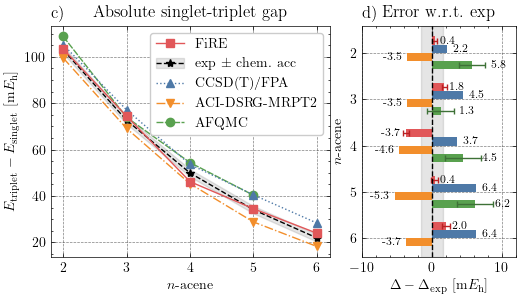

In [49]:

order = list(energies_kcal_per_mol.keys())
colors = ['e15759', '4e79a7', 'f28e2b', '59a14f', '9c755f', 'b07aa1', '76b7b2', 'ff9da7', 'edc948', 'bab0ac']
colors = [f"#{c}" for c in colors]
line_styles = [
    'solid',
    'dashed',
    'dotted',
    'dashdot',
    (0, (5, 1)),
    (0, (3, 5, 1, 5, 1, 5))
]

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(6, 3), width_ratios=[2, 1.1])
ax.plot(pd.Series(final_deltas)[order], 's', color=colors[0], label='FiRE', zorder=5, linestyle=line_styles[0])
ax.plot(reference.loc['ZPE-corr\'d exp'][order], '*', color='black', label='exp', zorder=-1, linestyle=line_styles[1])
ax.fill_between(range(len(order)), reference.loc['ZPE-corr\'d exp'][order] - 1.6, reference.loc['ZPE-corr\'d exp'][order] + 1.6, color='black', alpha=0.1, zorder=-10, label='exp $\pm$ chem. acc')
ax.plot(reference.loc['CCSD(T)/FPA'][order], '^', color=colors[1], label='CCSD(T)/FPA', zorder=3, linestyle=line_styles[2])
ax.plot(reference.loc['ACI-DSRG-MRPT2'][order], 'v', color=colors[2], label='ACI-DSRG-MRPT2', zorder=4, linestyle=line_styles[3])
ax.plot(reference.loc['AFQMC'][order], 'o', color=colors[3], label='AFQMC', zorder=2, linestyle=line_styles[4])
# ax.errorbar(range(len(order)), reference.loc['AFQMC'][order], afqmc_error, color=colors[3], zorder=2, capsize=4)
# ax.set_xlabel('$n$-acene')
ax.set_ylabel(r"$E_\text{triplet} - E_\text{singlet}$ [m$E_\text{h}$]")
ax.tick_params(axis='x', which='minor', bottom=False, top=False)
ax.set_title('Absolute singlet-triplet gap')
ax.set_xticks(range(len(order)), [2, 3, 4, 5, 6])
ax.set_xlabel('$n$-acene')
handles, labels = ax.get_legend_handles_labels()
legend_dict = dict(zip(labels, handles))
legend_dict['exp $\pm$ chem. acc'] = (legend_dict.pop('exp'), legend_dict['exp $\pm$ chem. acc'])
leg = ax.legend(legend_dict.values(), legend_dict.keys(), loc='upper right')

# ax2 = ax.inset_axes([0.45, 0.5, 0.55, 0.5])
x = np.arange(len(order))[::-1]
w = 0.175
n = 4
pos = x + (n+1)/2 * w
ax2.barh(pos := pos - w, pd.Series(final_deltas)[order] -reference.loc['ZPE-corr\'d exp'][order], height=w, color=colors[0], label='FiRE', zorder=10, linestyle=line_styles[0])
ax2.barh(pos := pos - w, reference.loc['CCSD(T)/FPA'][order] - reference.loc['ZPE-corr\'d exp'][order], height=w, color=colors[1], label='CCSD(T)/FPA', zorder=5, linestyle=line_styles[2])
ax2.barh(pos := pos - w, reference.loc['ACI-DSRG-MRPT2'][order] - reference.loc['ZPE-corr\'d exp'][order], height=w, color=colors[2], label='ACI-DSRG-MRPT2', zorder=6, linestyle=line_styles[3])
ax2.barh(pos := pos - w, reference.loc['AFQMC'][order] - reference.loc['ZPE-corr\'d exp'][order], height=w, color=colors[3], label='AFQMC', zorder=4, linestyle=line_styles[4])
for container in ax2.containers:
    pad = 14 if container.get_label() == 'AFQMC' else 4
    ax2.bar_label(container, fmt='%.1f', padding=pad, zorder=11, fontsize=8)
ax2.errorbar(pd.Series(final_deltas)[order] - reference.loc['ZPE-corr\'d exp'][order], x + (n+1)/2 * w - w, xerr=errors[order], color=scale_lightness(colors[0], 0.7), capsize=2, label='FiRE', linestyle='', zorder=10)
ax2.errorbar(reference.loc['AFQMC'][order] - reference.loc['ZPE-corr\'d exp'][order], pos, xerr=afqmc_error, color=scale_lightness(colors[3], 0.7), capsize=2, label='AFQMC', linestyle='', zorder=5)
ax2.axvline(0, color='black', zorder=100, linestyle=line_styles[1])
ax2.axvspan(-1.6, 1.6, color='black', alpha=0.1, zorder=-10, label='exp$\pm$ chem. acc')
ax2.set_yticks(x, [2, 3, 4, 5, 6])
ax2.set_ylabel('$n$-acene')
ax2.set_xlim(-10, 12)
ax2.tick_params(axis='y', which='minor', left=False, right=False)
ax2.set_xlabel(r"$\Delta - \Delta_\text{exp}$ [m$E_\text{h}$]")
ax2.set_title('Error w.r.t. exp')

for ax, label in zip((ax, ax2), "cd"):
    ax.text(0, 1.02, f"{label})", transform=ax.transAxes, va="bottom", ha="left", fontweight="bold", fontsize=12)

fig.subplots_adjust(wspace=0.15)
plt.savefig("acene_final.pdf", bbox_inches="tight")


# Stacked plot

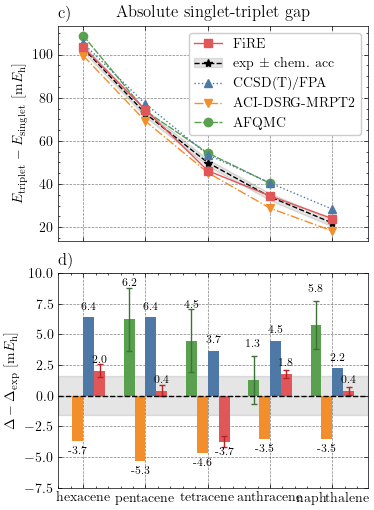

In [43]:
order = list(energies_kcal_per_mol.keys())
colors = ['e15759', '4e79a7', 'f28e2b', '59a14f', '9c755f', 'b07aa1', '76b7b2', 'ff9da7', 'edc948', 'bab0ac']
colors = [f"#{c}" for c in colors]
line_styles = [
    'solid',
    'dashed',
    'dotted',
    'dashdot',
    (0, (5, 1)),
    (0, (3, 5, 1, 5, 1, 5))
]

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(4, 6), height_ratios=[1, 1], sharex=True)
ax.plot(pd.Series(final_deltas)[order], 's', color=colors[0], label='FiRE', zorder=5, linestyle=line_styles[0])
ax.plot(reference.loc['ZPE-corr\'d exp'][order], '*', color='black', label='exp', zorder=-1, linestyle=line_styles[1])
ax.fill_between(range(len(order)), reference.loc['ZPE-corr\'d exp'][order] - 1.6, reference.loc['ZPE-corr\'d exp'][order] + 1.6, color='black', alpha=0.1, zorder=-10, label='exp $\pm$ chem. acc')
ax.plot(reference.loc['CCSD(T)/FPA'][order], '^', color=colors[1], label='CCSD(T)/FPA', zorder=3, linestyle=line_styles[2])
ax.plot(reference.loc['ACI-DSRG-MRPT2'][order], 'v', color=colors[2], label='ACI-DSRG-MRPT2', zorder=4, linestyle=line_styles[3])
ax.plot(reference.loc['AFQMC'][order], 'o', color=colors[3], label='AFQMC', zorder=2, linestyle=line_styles[4])
# ax.errorbar(range(len(order)), reference.loc['AFQMC'][order], afqmc_error, color=colors[3], zorder=2, capsize=4)
# ax.set_xlabel('$n$-acene')
ax.set_ylabel(r"$E_\text{triplet} - E_\text{singlet}$ [m$E_\text{h}$]")
ax.tick_params(axis='x', which='minor', bottom=False, top=False)
ax.set_title('Absolute singlet-triplet gap')
ax.set_xticks(range(len(order)), order)
handles, labels = ax.get_legend_handles_labels()
legend_dict = dict(zip(labels, handles))
legend_dict['exp $\pm$ chem. acc'] = (legend_dict.pop('exp'), legend_dict['exp $\pm$ chem. acc'])
leg = ax.legend(legend_dict.values(), legend_dict.keys(), loc='upper right')

# ax2 = ax.inset_axes([0.45, 0.5, 0.55, 0.5])
x = np.arange(len(order))[::-1]
w = 0.175
n = 4
pos = x + (n+1)/2 * w
ax2.bar(pos := pos - w, pd.Series(final_deltas)[order] -reference.loc['ZPE-corr\'d exp'][order], width=w, color=colors[0], label='FiRE', zorder=10, linestyle=line_styles[0])
ax2.bar(pos := pos - w, reference.loc['CCSD(T)/FPA'][order] - reference.loc['ZPE-corr\'d exp'][order], width=w, color=colors[1], label='CCSD(T)/FPA', zorder=5, linestyle=line_styles[2])
ax2.bar(pos := pos - w, reference.loc['ACI-DSRG-MRPT2'][order] - reference.loc['ZPE-corr\'d exp'][order], width=w, color=colors[2], label='ACI-DSRG-MRPT2', zorder=6, linestyle=line_styles[3])
ax2.bar(pos := pos - w, reference.loc['AFQMC'][order] - reference.loc['ZPE-corr\'d exp'][order], width=w, color=colors[3], label='AFQMC', zorder=4, linestyle=line_styles[4])
for container in ax2.containers:
    pad = 22 if container.get_label() == 'AFQMC' else 4
    ax2.bar_label(container, fmt='%.1f', padding=pad, zorder=11, fontsize=8)
ax2.errorbar(x + (n+1)/2 * w - w, pd.Series(final_deltas)[order] - reference.loc['ZPE-corr\'d exp'][order], yerr=errors[order], color=scale_lightness(colors[0], 0.7), capsize=2, label='FiRE', linestyle='', zorder=10)
ax2.errorbar(pos, reference.loc['AFQMC'][order] - reference.loc['ZPE-corr\'d exp'][order], yerr=afqmc_error, color=scale_lightness(colors[3], 0.7), capsize=2, label='AFQMC', linestyle='', zorder=5)
ax2.axhline(0, color='black', zorder=100, linestyle=line_styles[1])
ax2.axhspan(-1.6, 1.6, color='black', alpha=0.1, zorder=-10, label='exp$\pm$ chem. acc')
ax2.set_xticks(x, reference.columns)
ax2.set_ylim(-7.5, 10)
ax2.tick_params(axis='y', which='minor', left=False, right=False)
ax2.set_ylabel(r"$\Delta - \Delta_\text{exp}$ [m$E_\text{h}$]")

for ax, label in zip((ax, ax2), "cd"):
    ax.text(0, 1.02, f"{label})", transform=ax.transAxes, va="bottom", ha="left", fontweight="bold", fontsize=12)

fig.subplots_adjust(wspace=0.35, hspace=0.15)
plt.savefig("acene_final.pdf", bbox_inches="tight")


# Collect data from wandb

In [ ]:
api = wandb.Api()
runs = ["tum_daml_nicholas/acene/kiq6t01c", "tum_daml_nicholas/acene/5lsw3pnf"]
# ending = "_ccecpccpvdz"
ending = "_splus_new"
pattern = re.compile(f"{ending}(?:_from\\d{{6}})?$")
# ending = "_b3lyp"

runs = list(api.runs("tum_daml_nicholas/acene"))
runs = [r for r in runs if pattern.search(r.name) and 'opt/E' in r.summary]
runs = sorted(runs, key=lambda r: r.summary['_timestamp'])
_runs = defaultdict(lambda: defaultdict(list))
for r in runs:
    _runs[r.name.split("_")[1]][r.name.split("_")[2]].append(r)
runs = {k: dict(v) for k, v in _runs.items()}

energies = jax.tree.map(
    lambda r: pd.DataFrame(r.scan_history(keys=["opt/E", 'opt/E_std', "opt/step"])).set_index('opt/step').sort_index(), runs, is_leaf=lambda x: isinstance(x, wandb.apis.public.Run)
)
energies = {
    k: {
        s: pd.concat(d)
        for s, d in v.items()
    }
    for k, v in energies.items()
}


full_df = pd.concat([
    d[['opt/E_std']].rename(columns={'opt/E_std': (k, s)})[~d.index.duplicated(keep='first')]
    for k, v in energies.items()
    for s, d in v.items()
], axis=1)
tuples = full_df.transpose().index
new_columns = pd.MultiIndex.from_tuples(tuples, names=['Molecule', 'State'])
full_df.columns = new_columns
full_df.to_csv('acene_std.csv')

full_df = pd.concat([
    d.rename(columns={'opt/E': (k, s)})[~d.index.duplicated(keep='first')]
    for k, v in energies.items()
    for s, d in v.items()
], axis=1)
tuples = full_df.transpose().index
new_columns = pd.MultiIndex.from_tuples(tuples, names=['Molecule', 'State'])
full_df.columns = new_columns
full_df.to_csv('acene.csv')